# BM686 Deep Learning in Medical Imaging - Homework 4

## Kadir Berat YILDIRIM

Please work on the dataset of the 3rd homework:
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
and try to optimize & regularize the deep learning model for this data. Please report loss and
accuracy for the following scenarios:
- Different activation functions (relu, tanh, sigmoid)
- Different optimizers (adam, rmsprop, sgd)
- Different learning rate & decay with these optimizers
- With/without batch normalization layers
- With/without different ratios of dropout (0.25, 0.5)
- With/without preprocessing (normalization of the data)

---

Below is the wandb results for all the models trained in this notebook:

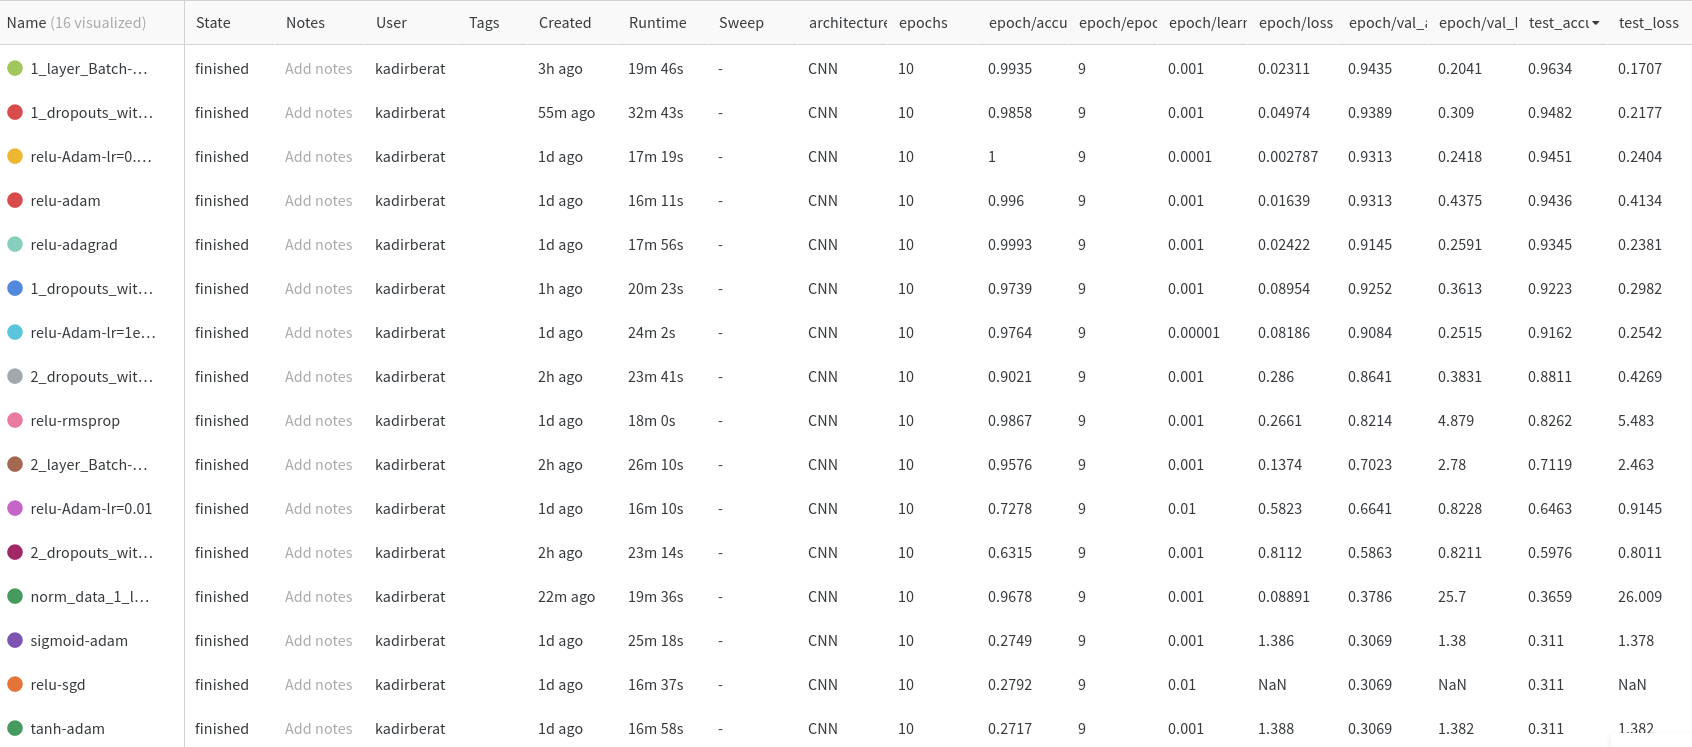

Or more visually, the test results are:

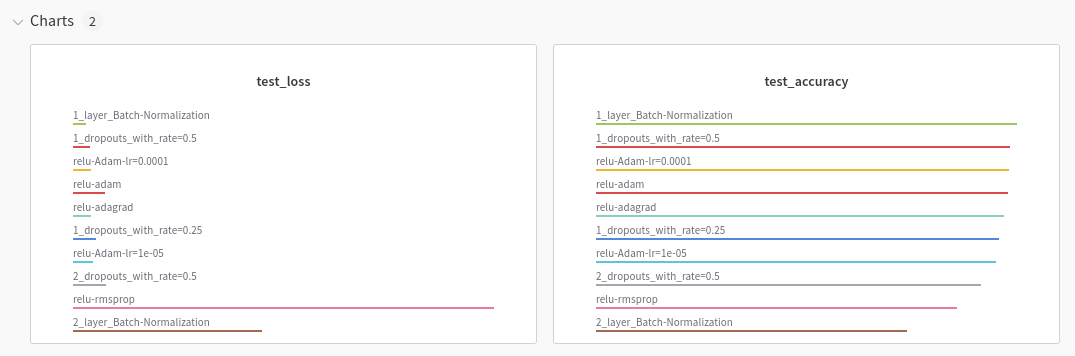

From these results, in the simple model I have created, adding 1 batch normalization layer before fully connected layer worked the best, with relu and adam.

Out of all optimizers and cost functions, adam with learning rate of 10**-4 and relu worked the best.

While the 2 dropout layer model was bad, adding one dropout layer before the fully connected layer (not before cnn, as indicated also in one stackoverflow discussion) had an okay result of 94% accuracy.

In [1]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import os
import warnings
warnings.filterwarnings('ignore')

# Reading Data

Same as in homework 3.

In [2]:
from sklearn.utils import shuffle

train_dir = './data/Training/'
test_dir = './data/Testing/'

train_paths, train_labels = [], []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [3]:
test_paths, test_labels = [], []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [4]:
def open_images(paths, img_size = 128):
    from tensorflow.keras.preprocessing.image import load_img
    
    images = []
    for path in paths:
        image = load_img(path, target_size = (img_size, img_size))
        images.append(image)
    return np.array(images)

X_train_pil = open_images(train_paths)
X_test_pil = open_images(test_paths)

2023-04-08 21:20:16.200279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print('X_train size: ', len(X_train_pil), '\tX_test size: ', len(X_test_pil), \
     '\nTrain label size: ', len(train_labels), '\tTest label size: ', len(test_labels))

X_train size:  5712 	X_test size:  1311 
Train label size:  5712 	Test label size:  1311


# Split Validation / Test Sets

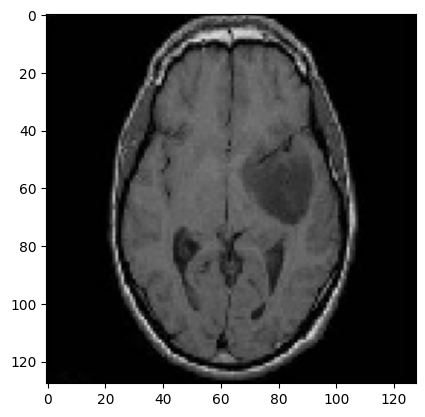

In [6]:
X_train = np.array([np.array(i) for i in X_train_pil])
X_val = np.array([np.array(i) for i in X_test_pil[:len(X_test_pil)//2]])
X_test = np.array([np.array(i) for i in X_test_pil[len(X_test_pil)//2:]])

plt.imshow(X_test[0])

In [7]:
X_train.shape

(5712, 128, 128, 3)

In [8]:
from keras.utils import to_categorical

# Create a mapping of str to int
types = ['notumor', 'glioma', 'meningioma', 'pituitary']
mapping = {types[i]:i for i in range(len(types))}

y_train = [mapping[train_labels[i]] for i in range(len(train_labels))]
y_val = [mapping[i] for i in test_labels[:len(test_labels)//2]]
y_test = [mapping[i] for i in test_labels[len(test_labels)//2:]]

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

# Model from Homework 3

I here take the best of the simple models I have created in homework 3, put it in a method called 'test_model' and start testing with it.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from wandb.keras import WandbMetricsLogger

def test_model(data, activation, optimizer, verbal = False):
    X_train, y_train, X_val, y_val, X_test, y_test = data
    #Basically the code above, I put it into a function to call and try easily
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation=activation, input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=3, activation=activation))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, callbacks=[WandbMetricsLogger()])

    score = model.evaluate(X_test, y_test_ohe, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})
    if verbal:
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return score[1]

# Different Activation Functions

Below I write a for loop to call the test method to try out different activations. Notice that I also start a new run on wandb for each for loop iteration.

In [12]:
import wandb

d = [X_train, y_train_ohe, X_val, y_val_ohe, X_test, y_test_ohe]

scores = {}
for activation in ['relu', 'tanh', 'sigmoid']:
    wandb.init(settings=wandb.Settings(start_method="fork"), 
        project="BM686-Deep_in_MR-Homework4",

        config={
        "architecture": "CNN",
        "epochs": 10,
        }
    )
    print('Testing activation: ', activation)
    scores[activation] = test_model(d, activation, 'adam', True)

Testing activation:  relu


2023-04-07 21:30:52.953261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 21:30:52.954929: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
179/179 [==============================] - 93s 516ms/step - loss: 12.7645 - accuracy: 0.7868 - val_loss: 0.4747 - val_accuracy: 0.8534
Epoch 2/10
179/179 [==============================] - 98s 545ms/step - loss: 0.2194 - accuracy: 0.9238 - val_loss: 0.3011 - val_accuracy: 0.9176
Epoch 3/10
179/179 [==============================] - 100s 560ms/step - loss: 0.0760 - accuracy: 0.9748 - val_loss: 0.2900 - val_accuracy: 0.9252
Epoch 4/10
179/179 [==============================] - 98s 549ms/step - loss: 0.0348 - accuracy: 0.9893 - val_loss: 0.3321 - val_accuracy: 0.9344
Epoch 5/10
179/179 [==============================] - 103s 577ms/step - loss: 0.0116 - accuracy: 0.9974 - val_loss: 0.3510 - val_accuracy: 0.9374
Epoch 6/10
179/179 [==============================] - 95s 531ms/step - loss: 0.0341 - accuracy: 0.9911 - val_loss: 0.3448 - val_accuracy: 0.9344
Epoch 7/10
179/179 [==============================] - 91s 507ms/step - loss: 0.0416 - accuracy: 0.9888 - val_loss: 0.4672 - val

epoch/accuracy,▁▆▇████▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▇████▄▇▇
epoch/val_loss,▆▁▁▂▃▂▆█▅▅
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.99597
epoch/epoch,9
epoch/learning_rate,0.001


Testing activation:  tanh
Epoch 1/10
179/179 [==============================] - 102s 568ms/step - loss: 2.6110 - accuracy: 0.2440 - val_loss: 1.3859 - val_accuracy: 0.2351
Epoch 2/10
179/179 [==============================] - 101s 565ms/step - loss: 1.3862 - accuracy: 0.2708 - val_loss: 1.3795 - val_accuracy: 0.3069
Epoch 3/10
179/179 [==============================] - 100s 560ms/step - loss: 1.3861 - accuracy: 0.2708 - val_loss: 1.3847 - val_accuracy: 0.2351
Epoch 4/10
179/179 [==============================] - 100s 559ms/step - loss: 1.3858 - accuracy: 0.2731 - val_loss: 1.3789 - val_accuracy: 0.3069
Epoch 5/10
179/179 [==============================] - 101s 563ms/step - loss: 1.3886 - accuracy: 0.2679 - val_loss: 1.3798 - val_accuracy: 0.3069
Epoch 6/10
179/179 [==============================] - 100s 558ms/step - loss: 1.3870 - accuracy: 0.2631 - val_loss: 1.3855 - val_accuracy: 0.3069
Epoch 7/10
179/179 [==============================] - 101s 564ms/step - loss: 1.3887 - accuracy: 0

epoch/accuracy,▁▇▇█▇▆▅▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁█▁████▁██
epoch/val_loss,▅▁▄▁▁▅▃█▂▃
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.27171
epoch/epoch,9
epoch/learning_rate,0.001


Testing activation:  sigmoid
Epoch 1/10
179/179 [==============================] - 105s 583ms/step - loss: 1.7333 - accuracy: 0.2421 - val_loss: 1.3815 - val_accuracy: 0.3069
Epoch 2/10
179/179 [==============================] - 110s 615ms/step - loss: 1.3848 - accuracy: 0.2670 - val_loss: 1.3813 - val_accuracy: 0.3069
Epoch 3/10
179/179 [==============================] - 105s 589ms/step - loss: 1.3850 - accuracy: 0.2759 - val_loss: 1.3834 - val_accuracy: 0.2351
Epoch 4/10
179/179 [==============================] - 103s 575ms/step - loss: 1.3849 - accuracy: 0.2705 - val_loss: 1.3847 - val_accuracy: 0.2351
Epoch 5/10
179/179 [==============================] - 106s 591ms/step - loss: 1.3850 - accuracy: 0.2714 - val_loss: 1.3829 - val_accuracy: 0.3069
Epoch 6/10
179/179 [==============================] - 101s 562ms/step - loss: 1.3849 - accuracy: 0.2728 - val_loss: 1.3784 - val_accuracy: 0.3069
Epoch 7/10
179/179 [==============================] - 107s 598ms/step - loss: 1.3854 - accuracy

# Different Optimizer Functions

Below I try 4 optimizers (adam, rmsprop, sgd and adagrad) in the same algorithm using relu for activation function.

In [14]:
for optimizer in ['rmsprop', 'sgd', 'adagrad']:
    wandb.init(settings=wandb.Settings(start_method="fork"), 
        project="BM686-Deep_in_MR-Homework4",
        name = 'relu-'+optimizer,
        config={
        "architecture": "CNN",
        "epochs": 10,
        }
    )
    print('Testing optimizer: ', optimizer)
    scores[optimizer] = test_model(d, 'relu', optimizer, True)

epoch/accuracy,▁▆▇▆▇▇█▇▆▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,██▁▁██████
epoch/val_loss,▄▄▇█▆▁▃▂▃▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.27486
epoch/epoch,9
epoch/learning_rate,0.001


Testing optimizer:  rmsprop
Epoch 1/10
179/179 [==============================] - 103s 575ms/step - loss: 8.4490 - accuracy: 0.7931 - val_loss: 2.5435 - val_accuracy: 0.7038
Epoch 2/10
179/179 [==============================] - 100s 558ms/step - loss: 0.4865 - accuracy: 0.9034 - val_loss: 0.3618 - val_accuracy: 0.8962
Epoch 3/10
179/179 [==============================] - 101s 564ms/step - loss: 1.2970 - accuracy: 0.9391 - val_loss: 0.9663 - val_accuracy: 0.8855
Epoch 4/10
179/179 [==============================] - 102s 568ms/step - loss: 0.6643 - accuracy: 0.9573 - val_loss: 0.4196 - val_accuracy: 0.9099
Epoch 5/10
179/179 [==============================] - 101s 566ms/step - loss: 0.7188 - accuracy: 0.9695 - val_loss: 0.4000 - val_accuracy: 0.9374
Epoch 6/10
179/179 [==============================] - 104s 582ms/step - loss: 0.1747 - accuracy: 0.9772 - val_loss: 0.4486 - val_accuracy: 0.9313
Epoch 7/10
179/179 [==============================] - 121s 677ms/step - loss: 0.5957 - accuracy:

epoch/accuracy,▁▅▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▂▁▁▁▁▃▃▁
epoch/val_accuracy,▁▇▆▇████▃▄
epoch/val_loss,▂▁▁▁▁▁▁▁█▃
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.98669
epoch/epoch,9
epoch/learning_rate,0.001


Testing optimizer:  sgd
Epoch 1/10
179/179 [==============================] - 100s 557ms/step - loss: nan - accuracy: 0.2782 - val_loss: nan - val_accuracy: 0.3069
Epoch 2/10
179/179 [==============================] - 99s 552ms/step - loss: nan - accuracy: 0.2792 - val_loss: nan - val_accuracy: 0.3069
Epoch 3/10
179/179 [==============================] - 93s 523ms/step - loss: nan - accuracy: 0.2792 - val_loss: nan - val_accuracy: 0.3069
Epoch 4/10
179/179 [==============================] - 87s 485ms/step - loss: nan - accuracy: 0.2792 - val_loss: nan - val_accuracy: 0.3069
Epoch 5/10
179/179 [==============================] - 94s 524ms/step - loss: nan - accuracy: 0.2792 - val_loss: nan - val_accuracy: 0.3069
Epoch 6/10
179/179 [==============================] - 88s 493ms/step - loss: nan - accuracy: 0.2792 - val_loss: nan - val_accuracy: 0.3069
Epoch 7/10
179/179 [==============================] - 89s 496ms/step - loss: nan - accuracy: 0.2792 - val_loss: nan - val_accuracy: 0.3069
Ep

epoch/accuracy,▁█████████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
epoch/accuracy,0.27924
epoch/epoch,9
epoch/learning_rate,0.01
epoch/loss,nan
epoch/val_accuracy,0.30687
epoch/val_loss,nan


Testing optimizer:  adagrad
Epoch 1/10
179/179 [==============================] - 94s 524ms/step - loss: 18.0515 - accuracy: 0.6416 - val_loss: 0.9101 - val_accuracy: 0.7603
Epoch 2/10
179/179 [==============================] - 93s 520ms/step - loss: 0.3647 - accuracy: 0.8731 - val_loss: 0.4673 - val_accuracy: 0.8366
Epoch 3/10
179/179 [==============================] - 93s 519ms/step - loss: 0.1921 - accuracy: 0.9321 - val_loss: 0.3583 - val_accuracy: 0.8733
Epoch 4/10
179/179 [==============================] - 103s 574ms/step - loss: 0.1141 - accuracy: 0.9662 - val_loss: 0.3071 - val_accuracy: 0.9053
Epoch 5/10
179/179 [==============================] - 94s 524ms/step - loss: 0.0765 - accuracy: 0.9827 - val_loss: 0.3007 - val_accuracy: 0.8977
Epoch 6/10
179/179 [==============================] - 94s 523ms/step - loss: 0.0551 - accuracy: 0.9921 - val_loss: 0.2673 - val_accuracy: 0.9115
Epoch 7/10
179/179 [==============================] - 96s 536ms/step - loss: 0.0420 - accuracy: 0.99


# Different Learning Rates and Decays

Below I try different learning rates. Notice I do not try 10**-3 since it is the default value and already been tried above.

In [15]:
from keras.optimizers import Adam

for lr in [10**(-2), 10**(-4), 10**(-5)]: # Default is 10**(-3) so I do not try that one here again, it is above
    wandb.init(settings=wandb.Settings(start_method="fork"), 
        project="BM686-Deep_in_MR-Homework4",
        name = 'relu-Adam-lr='+str(lr),
        config={
        "architecture": "CNN",
        "epochs": 10,
        }
    )
    opt = Adam(learning_rate=lr)
    print('Testing learning rate: ', lr)
    scores['Adam_lr='+str(lr)] = test_model(d, 'relu', opt, True)

epoch/accuracy,▁▆▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▇▇███▇█
epoch/val_loss,█▃▂▂▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.9993
epoch/epoch,9
epoch/learning_rate,0.001


Testing learning rate:  0.01
Epoch 1/10
179/179 [==============================] - 101s 564ms/step - loss: 37.7256 - accuracy: 0.5539 - val_loss: 1.1937 - val_accuracy: 0.6397
Epoch 2/10
179/179 [==============================] - 95s 531ms/step - loss: 0.7749 - accuracy: 0.6590 - val_loss: 0.8341 - val_accuracy: 0.6397
Epoch 3/10
179/179 [==============================] - 94s 524ms/step - loss: 0.7119 - accuracy: 0.6856 - val_loss: 0.7982 - val_accuracy: 0.6260
Epoch 4/10
179/179 [==============================] - 94s 524ms/step - loss: 0.7043 - accuracy: 0.6838 - val_loss: 0.7577 - val_accuracy: 0.6305
Epoch 5/10
179/179 [==============================] - 95s 530ms/step - loss: 0.7089 - accuracy: 0.6842 - val_loss: 0.7826 - val_accuracy: 0.6672
Epoch 6/10
179/179 [==============================] - 94s 523ms/step - loss: 0.6362 - accuracy: 0.7122 - val_loss: 0.8190 - val_accuracy: 0.6748
Epoch 7/10
179/179 [==============================] - 95s 529ms/step - loss: 0.6137 - accuracy: 0.7

epoch/accuracy,▁▅▆▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▃▃▁▂▆▇▆█▇▆
epoch/val_loss,█▂▂▁▂▂▁▃▂▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.72777
epoch/epoch,9
epoch/learning_rate,0.01


Testing learning rate:  0.0001
Epoch 1/10
179/179 [==============================] - 96s 532ms/step - loss: 8.6349 - accuracy: 0.6861 - val_loss: 0.5572 - val_accuracy: 0.7893
Epoch 2/10
179/179 [==============================] - 98s 546ms/step - loss: 0.2910 - accuracy: 0.8915 - val_loss: 0.3719 - val_accuracy: 0.8672
Epoch 3/10
179/179 [==============================] - 104s 580ms/step - loss: 0.1312 - accuracy: 0.9575 - val_loss: 0.2869 - val_accuracy: 0.9115
Epoch 4/10
179/179 [==============================] - 103s 576ms/step - loss: 0.0508 - accuracy: 0.9893 - val_loss: 0.2921 - val_accuracy: 0.9084
Epoch 5/10
179/179 [==============================] - 105s 584ms/step - loss: 0.0289 - accuracy: 0.9961 - val_loss: 0.2646 - val_accuracy: 0.9115
Epoch 6/10
179/179 [==============================] - 104s 580ms/step - loss: 0.0177 - accuracy: 0.9981 - val_loss: 0.2541 - val_accuracy: 0.9191
Epoch 7/10
179/179 [==============================] - 104s 581ms/step - loss: 0.0159 - accuracy

epoch/accuracy,▁▆▇███████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇▇▇▇▇███
epoch/val_loss,█▄▂▂▂▁▃▂▁▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,1.0
epoch/epoch,9
epoch/learning_rate,0.0001


Testing learning rate:  1e-05
Epoch 1/10
179/179 [==============================] - 104s 580ms/step - loss: 1.6228 - accuracy: 0.5634 - val_loss: 0.8978 - val_accuracy: 0.6534
Epoch 2/10
179/179 [==============================] - 105s 587ms/step - loss: 0.6965 - accuracy: 0.7167 - val_loss: 0.7486 - val_accuracy: 0.7008
Epoch 3/10
179/179 [==============================] - 102s 569ms/step - loss: 0.5438 - accuracy: 0.7899 - val_loss: 0.6212 - val_accuracy: 0.7481
Epoch 4/10
179/179 [==============================] - 104s 583ms/step - loss: 0.4193 - accuracy: 0.8358 - val_loss: 0.5507 - val_accuracy: 0.7863
Epoch 5/10
179/179 [==============================] - 109s 611ms/step - loss: 0.3257 - accuracy: 0.8732 - val_loss: 0.4546 - val_accuracy: 0.8168
Epoch 6/10
179/179 [==============================] - 105s 589ms/step - loss: 0.2487 - accuracy: 0.9053 - val_loss: 0.4013 - val_accuracy: 0.8443
Epoch 7/10
179/179 [==============================] - 103s 574ms/step - loss: 0.2061 - accurac

# Batch Normalization Layers

Below I take our winners relu and adam to make a model this time including batch normalization layer. First I try with 1 batch normalization, then 2 of them.

In [10]:
from keras.layers import BatchNormalization

def test_model_1batch(data, activation, optimizer, verbal = False):
    X_train, y_train, X_val, y_val, X_test, y_test = data
    #Basically the code above, I put it into a function to call and try easily
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation=activation, input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation=activation))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, callbacks=[WandbMetricsLogger()])

    score = model.evaluate(X_test, y_test_ohe, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})
    if verbal:
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return score[1]

In [11]:
import wandb

d = [X_train, y_train_ohe, X_val, y_val_ohe, X_test, y_test_ohe]
scores = {}

wandb.init(settings=wandb.Settings(start_method="fork"), 
    project="BM686-Deep_in_MR-Homework4",
    name = '1_layer_Batch-Normalization',
    config={
    "architecture": "CNN",
    "epochs": 10,
    }
)
scores['bacth_norm_1'] = test_model_1batch(d, 'relu', 'adam', True)

wandb: Currently logged in as: kadirberatyildirim (mimlab). Use `wandb login --relogin` to force relogin


2023-04-08 21:20:45.510534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 21:20:45.511394: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
179/179 [==============================] - 119s 662ms/step - loss: 3.2108 - accuracy: 0.7229 - val_loss: 0.6703 - val_accuracy: 0.7344
Epoch 2/10
179/179 [==============================] - 102s 571ms/step - loss: 0.2722 - accuracy: 0.9055 - val_loss: 0.3984 - val_accuracy: 0.8534
Epoch 3/10
179/179 [==============================] - 135s 753ms/step - loss: 0.1239 - accuracy: 0.9566 - val_loss: 0.2013 - val_accuracy: 0.9252
Epoch 4/10
179/179 [==============================] - 133s 746ms/step - loss: 0.1021 - accuracy: 0.9676 - val_loss: 0.2563 - val_accuracy: 0.9206
Epoch 5/10
179/179 [==============================] - 131s 731ms/step - loss: 0.0667 - accuracy: 0.9816 - val_loss: 0.1682 - val_accuracy: 0.9466
Epoch 6/10
179/179 [==============================] - 117s 655ms/step - loss: 0.0385 - accuracy: 0.9881 - val_loss: 0.1940 - val_accuracy: 0.9420
Epoch 7/10
179/179 [==============================] - 109s 608ms/step - loss: 0.0657 - accuracy: 0.9828 - val_loss: 0.2060 -

In [12]:
from keras.layers import BatchNormalization

def test_model_2batch(data, activation, optimizer, verbal = False):
    X_train, y_train, X_val, y_val, X_test, y_test = data
    #Basically the code above, I put it into a function to call and try easily
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation=activation, input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, callbacks=[WandbMetricsLogger()])

    score = model.evaluate(X_test, y_test_ohe, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})
    if verbal:
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return score[1]

In [13]:
wandb.init(settings=wandb.Settings(start_method="fork"), 
    project="BM686-Deep_in_MR-Homework4",
    name = '2_layer_Batch-Normalization',
    config={
    "architecture": "CNN",
    "epochs": 10,
    }
)
scores['bacth_norm_2'] = test_model_2batch(d, 'relu', 'adam', True)

epoch/accuracy,▁▆▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇▇███▇██
epoch/val_loss,█▄▁▂▁▁▂▂▂▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.99352
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
179/179 [==============================] - 111s 621ms/step - loss: 1.7630 - accuracy: 0.5926 - val_loss: 1.1175 - val_accuracy: 0.5557
Epoch 2/10
179/179 [==============================] - 111s 618ms/step - loss: 0.6722 - accuracy: 0.7197 - val_loss: 0.7226 - val_accuracy: 0.7618
Epoch 3/10
179/179 [==============================] - 125s 699ms/step - loss: 0.4715 - accuracy: 0.8086 - val_loss: 0.4387 - val_accuracy: 0.8000
Epoch 4/10
179/179 [==============================] - 111s 619ms/step - loss: 0.3397 - accuracy: 0.8654 - val_loss: 0.5256 - val_accuracy: 0.7740
Epoch 5/10
179/179 [==============================] - 119s 663ms/step - loss: 0.2539 - accuracy: 0.8906 - val_loss: 0.4272 - val_accuracy: 0.8458
Epoch 6/10
179/179 [==============================] - 131s 731ms/step - loss: 0.2063 - accuracy: 0.9142 - val_loss: 0.4372 - val_accuracy: 0.8504
Epoch 7/10
179/179 [==============================] - 111s 619ms/step - loss: 0.1841 - accuracy: 0.9282 - val_loss: 0.4717 -

# Dropout Layers

Below I start with trying 2 dropout layers; one before second convolution layer and one before fully connected layer. Then I try a model with only one dropout layer; just before the fully connected layer. 

In [14]:
from keras.layers import Dropout

def test_model_drop2(data, activation, optimizer, drop_rate, verbal = False):
    X_train, y_train, X_val, y_val, X_test, y_test = data
    #Basically the code above, I put it into a function to call and try easily
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation=activation, input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(Conv2D(32, kernel_size=3, activation=activation))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, callbacks=[WandbMetricsLogger()])

    score = model.evaluate(X_test, y_test_ohe, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})
    if verbal:
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return score[1]

In [15]:
for drop_rate in [0.25, 0.5]:
    wandb.init(settings=wandb.Settings(start_method="fork"), 
        project="BM686-Deep_in_MR-Homework4",
        name = '2_dropouts_with_rate='+str(drop_rate),
        config={
        "architecture": "CNN",
        "epochs": 10,
        }
    )
    print('Testing rate: ', drop_rate)
    scores['2_dropouts_with_rate='+str(drop_rate)] = test_model_drop2(d, 'relu', 'adam', drop_rate, True)

epoch/accuracy,▁▃▅▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▅▆▅▇▇▇▆█▄
epoch/val_loss,▃▂▁▂▁▁▂▃▁█
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.95763
epoch/epoch,9
epoch/learning_rate,0.001


Testing rate:  0.25
Epoch 1/10
179/179 [==============================] - 145s 810ms/step - loss: 3.5920 - accuracy: 0.3761 - val_loss: 1.6462 - val_accuracy: 0.4260
Epoch 2/10
179/179 [==============================] - 135s 756ms/step - loss: 1.1423 - accuracy: 0.4380 - val_loss: 1.0512 - val_accuracy: 0.5099
Epoch 3/10
179/179 [==============================] - 138s 772ms/step - loss: 1.0609 - accuracy: 0.5025 - val_loss: 0.9864 - val_accuracy: 0.5344
Epoch 4/10
179/179 [==============================] - 143s 797ms/step - loss: 1.0176 - accuracy: 0.5145 - val_loss: 0.9359 - val_accuracy: 0.5466
Epoch 5/10
179/179 [==============================] - 137s 768ms/step - loss: 0.9793 - accuracy: 0.5273 - val_loss: 0.9231 - val_accuracy: 0.5374
Epoch 6/10
179/179 [==============================] - 136s 758ms/step - loss: 0.9853 - accuracy: 0.5200 - val_loss: 0.9224 - val_accuracy: 0.5542
Epoch 7/10
179/179 [==============================] - 136s 759ms/step - loss: 0.9462 - accuracy: 0.5376 

epoch/accuracy,▁▃▄▅▅▅▅▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▅▆▆█▇▇
epoch/val_loss,█▃▂▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.63148
epoch/epoch,9
epoch/learning_rate,0.001


Testing rate:  0.5
Epoch 1/10
179/179 [==============================] - 135s 755ms/step - loss: 4.7032 - accuracy: 0.5973 - val_loss: 0.9476 - val_accuracy: 0.6473
Epoch 2/10
179/179 [==============================] - 136s 760ms/step - loss: 0.6847 - accuracy: 0.7048 - val_loss: 0.7018 - val_accuracy: 0.7511
Epoch 3/10
179/179 [==============================] - 136s 758ms/step - loss: 0.5576 - accuracy: 0.7507 - val_loss: 0.6361 - val_accuracy: 0.7893
Epoch 4/10
179/179 [==============================] - 136s 762ms/step - loss: 0.4998 - accuracy: 0.7903 - val_loss: 0.5551 - val_accuracy: 0.7985
Epoch 5/10
179/179 [==============================] - 145s 809ms/step - loss: 0.4782 - accuracy: 0.7950 - val_loss: 0.6335 - val_accuracy: 0.7298
Epoch 6/10
179/179 [==============================] - 143s 799ms/step - loss: 0.4025 - accuracy: 0.8395 - val_loss: 0.4652 - val_accuracy: 0.8168
Epoch 7/10
179/179 [==============================] - 135s 751ms/step - loss: 0.3658 - accuracy: 0.8620 -

In [16]:
from keras.layers import Dropout

def test_model_drop1(data, activation, optimizer, drop_rate, verbal = False):
    X_train, y_train, X_val, y_val, X_test, y_test = data
    #Basically the code above, I put it into a function to call and try easily
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation=activation, input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation=activation))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, callbacks=[WandbMetricsLogger()])

    score = model.evaluate(X_test, y_test_ohe, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})
    if verbal:
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return score[1]

In [17]:
for drop_rate in [0.25, 0.5]:
    wandb.init(settings=wandb.Settings(start_method="fork"), 
        project="BM686-Deep_in_MR-Homework4",
        name = '1_dropouts_with_rate='+str(drop_rate),
        config={
        "architecture": "CNN",
        "epochs": 10,
        }
    )
    print('Testing rate: ', drop_rate)
    scores['1_dropouts_with_rate='+str(drop_rate)] = test_model_drop1(d, 'relu', 'adam', drop_rate, True)

epoch/accuracy,▁▃▅▅▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▆▄▆▇███
epoch/val_loss,█▅▄▃▄▂▂▂▁▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.90214
epoch/epoch,9
epoch/learning_rate,0.001


Testing rate:  0.25
Epoch 1/10
179/179 [==============================] - 128s 713ms/step - loss: 2.5437 - accuracy: 0.6850 - val_loss: 0.7051 - val_accuracy: 0.7221
Epoch 2/10
179/179 [==============================] - 125s 695ms/step - loss: 0.3858 - accuracy: 0.8423 - val_loss: 0.4010 - val_accuracy: 0.8168
Epoch 3/10
179/179 [==============================] - 127s 711ms/step - loss: 0.2995 - accuracy: 0.8953 - val_loss: 0.3110 - val_accuracy: 0.8870
Epoch 4/10
179/179 [==============================] - 118s 657ms/step - loss: 0.1856 - accuracy: 0.9333 - val_loss: 0.2496 - val_accuracy: 0.9008
Epoch 5/10
179/179 [==============================] - 118s 659ms/step - loss: 0.1027 - accuracy: 0.9613 - val_loss: 0.2301 - val_accuracy: 0.9298
Epoch 6/10
179/179 [==============================] - 123s 688ms/step - loss: 0.0599 - accuracy: 0.9788 - val_loss: 0.1709 - val_accuracy: 0.9389
Epoch 7/10
179/179 [==============================] - 125s 698ms/step - loss: 0.0499 - accuracy: 0.9835 

epoch/accuracy,▁▅▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▇██▇▇▇█
epoch/val_loss,█▄▃▂▂▁▂▄▂▃
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.97391
epoch/epoch,9
epoch/learning_rate,0.001


Testing rate:  0.5
Epoch 1/10
179/179 [==============================] - 120s 668ms/step - loss: 1.9639 - accuracy: 0.7162 - val_loss: 0.6654 - val_accuracy: 0.7542
Epoch 2/10
179/179 [==============================] - 117s 654ms/step - loss: 0.3179 - accuracy: 0.8958 - val_loss: 0.4797 - val_accuracy: 0.8061
Epoch 3/10
179/179 [==============================] - 117s 651ms/step - loss: 0.1878 - accuracy: 0.9366 - val_loss: 0.2653 - val_accuracy: 0.8992
Epoch 4/10
179/179 [==============================] - 118s 659ms/step - loss: 0.1107 - accuracy: 0.9673 - val_loss: 0.2413 - val_accuracy: 0.9328
Epoch 5/10
179/179 [==============================] - 118s 660ms/step - loss: 0.0552 - accuracy: 0.9809 - val_loss: 0.2943 - val_accuracy: 0.9252
Epoch 6/10
179/179 [==============================] - 115s 642ms/step - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.2613 - val_accuracy: 0.9389
Epoch 7/10
179/179 [==============================] - 116s 650ms/step - loss: 0.0822 - accuracy: 0.9732 -

# Data Normalization

I will take the best model so far, which is the relu/adam with 1 layer batch normalization added and try it with a normalized data.

In [19]:
from keras.layers import BatchNormalization

def test_model_1batch(data, activation, optimizer, verbal = False):
    X_train, y_train, X_val, y_val, X_test, y_test = data
    #Basically the code above, I put it into a function to call and try easily
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, activation=activation, input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation=activation))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, callbacks=[WandbMetricsLogger()])

    score = model.evaluate(X_test, y_test_ohe, verbose=0)
    wandb.log({"test_accuracy": score[1], 'test_loss':score[0]})
    if verbal:
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    return score[1]

In [31]:
X_train_norm = X_train / np.linalg.norm(X_train)
X_val_norm = X_val / np.linalg.norm(X_val)
X_test_norm = X_test / np.linalg.norm(X_test)

d = [X_train_norm, y_train_ohe, X_val_norm, y_val_ohe, X_test_norm, y_test_ohe]

wandb.init(settings=wandb.Settings(start_method="fork"), 
    project="BM686-Deep_in_MR-Homework4",
    name = 'norm_data_1_layer_Batch-Normalization',
    config={
    "architecture": "CNN",
    "epochs": 10,
    }
)
scores['normalized_data'] = test_model_1batch(d, 'relu', 'adam', True)

epoch/accuracy,▁▆▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▆█▇███▇█
epoch/val_loss,█▅▂▁▂▁▁▁▃▂
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.98582
epoch/epoch,9
epoch/learning_rate,0.001


Epoch 1/10
179/179 [==============================] - 131s 729ms/step - loss: 0.9826 - accuracy: 0.5599 - val_loss: 1.1827 - val_accuracy: 0.5847
Epoch 2/10
179/179 [==============================] - 107s 600ms/step - loss: 0.4592 - accuracy: 0.8417 - val_loss: 0.9052 - val_accuracy: 0.6901
Epoch 3/10
179/179 [==============================] - 106s 593ms/step - loss: 0.3325 - accuracy: 0.8794 - val_loss: 9.5868 - val_accuracy: 0.2962
Epoch 4/10
179/179 [==============================] - 113s 632ms/step - loss: 0.2292 - accuracy: 0.9132 - val_loss: 8.9910 - val_accuracy: 0.4137
Epoch 5/10
179/179 [==============================] - 111s 618ms/step - loss: 0.1804 - accuracy: 0.9343 - val_loss: 19.2344 - val_accuracy: 0.3786
Epoch 6/10
179/179 [==============================] - 106s 591ms/step - loss: 0.1377 - accuracy: 0.9515 - val_loss: 34.8070 - val_accuracy: 0.3618
Epoch 7/10
179/179 [==============================] - 117s 657ms/step - loss: 0.1123 - accuracy: 0.9608 - val_loss: 179.29